Wired CSV
---------

We have a photo and a CSV file. NOTE: The flag does not follow the CTF{...} format, but is clearly marked as the flag. Please add the CTF{...} around the flag manually when submitting.

Let's start by looking at the contents of the provided zip:

In [2]:
import glob
glob.glob("wired-csv/*")

['wired-csv\\pokey_kbd_scan.gif', 'wired-csv\\wires.jpg']

In [3]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url="wired-csv/wires.jpg")

Ok, so we have a scope/logic analyzer connected to an IC on a fairly large circuit board.
- The analyzer seems to be from [Salae](https://www.saleae.com/).
- On the IC, we see the following markings:
    
```
AMI 8327VT
CO12294B-01
CO3051
(C) KOREA
```

When we search for `CO12294B-01`, we [find](https://www.atarimax.com/jindroush.atari.org/achip.html) the IC is a 'POKEY', and [Wikipedia](https://en.wikipedia.org/wiki/POKEY) has an extensive page on it, including a pinout:

![POKEY pinout](https://upload.wikimedia.org/wikipedia/commons/thumb/9/99/Atari_POKEY.svg/202px-Atari_POKEY.svg.png)
[source](https://commons.wikimedia.org/wiki/File:Atari_POKEY.svg).

We can now make a pinout chart:

| CHANNEL | CABLE | PIN | SIGNAL          |
|---------|-------|-----|-----------------|
|  GND    | black | 1   | $Vcc$           |
|  0      | black | 23  | $\overline{K0}$ |
|  1      | brown | 22  | $\overline{K1}$ |
|  2      | red   | 21  | $\overline{K2}$ |
|  3      | orange| 20  | $K3$            |
|  4      | yellow| 19  | $K4$            |
|  5      | green | 18  | $\overline{K5}$ |
|  6      | blue  | 25  | $\overline{KR1}$|
|  7      | purple| 16  | $\overline{KR2}$|


The next question is what these signals actually mean. Wikipedia notes:

> K0 - K5	23, 22, 21, 20, 19, 18	Keyboard Scan Output
>
> KR1 - KR2	25, 16	Keyboard Row strobe Input

Which shows we're dealing with keyboard I/O. With some more Googling, we find [an extended POKEY description](http://krap.pl/mirrorz/atari/homepage.ntlworld.com/kryten_droid/Atari/800XL/atari_hw/pokey.htm#keyboard%20scan), which includes the following keyboard matrix diagram:

![keyboard matrix diagram](wired-csv/pokey_kbd_scan.gif)

and describes the behavior:

> When the keyboard scanner is enabled by the SKTL register, the binary counter begins to count, once per line. If the !KR1 line goes low, the value of the binary counter is transferred to the compare latch. This will be the key code to be debounced. If !KR1 goes low before the next time the binary counter equals the compare latch the there are two keys depressed and both are ignored. If the binary counter equals the compare latch and !KR1 is high, then the key is bouncing and is ignored, but if !KR1 is low then the key is valid and it is transferrred to the keycode latch for reading by the CPU. An IRQ is also sent indicating the key is ready. As soon as !KR1 is low and the binary counter equals the compare latch and !KR1 is high, then the key is debounced and another key can be looked for. But if !KR1 is low, then the key is bouncing and is assumed to be still pressed.

So K0...K6 are a binary counter, the two 4051 ICs then form a matrix where at any point in time only a single crossing is sampled, and if a key is pressed, this will result in a low !KR1 (connected to GND through the bottom 4051) at that specific time.

Now that we have a rough idea of what signals are being measured, let's look at the actual data. To do so, we extract the 7z file and take a quick look at the contained csv file:

```
 Time [s],Wire6-Analog,Wire7-Analog, Time [s],Wire0-Digital, Time [s],Wire1-Digital, Time [s],Wire2-Digital, Time [s],Wire3-Digital, Time [s],Wire4-Digital, Time [s],Wire5-Digital, Time [s],Wire6-Digital, Time [s],Wire7-Digital
0.000000000000000, 4.768121242523193, 4.773899555206299, 0.000000000000000, 0, 0.000000000000000, 0, 0.000000000000000, 0, 0.000000000000000, 1, 0.000000000000000, 0, 0.000000000000000, 0, 0.000000000000000, 1, 0.000000000000000, 1
0.000008000000000, 4.768121242523193, 4.773899555206299, 0.000000990000000, 1, 0.000065560000000, 1, 0.000194380000000, 1, 0.000451750000000, 0, 0.000452070000000, 1, 0.001480790000000, 1, 1.468471380000000, 0, 2.503182740000000, 0
0.000016000000000, 4.773141384124756, 4.778934478759766, 0.000065230000000, 0, 0.000194070000000, 0, 0.000451450000000, 0, 0.000965990000000, 1, 0.001480440000000, 0, 0.003537600000000, 0, 1.468535670000000, 1, 2.503689840000000, 1
```

So we have two analog signals for !KR1 and !KR2, and digital signals for all the connected pins. There is one shared timebase for the analog signals, and independent timebases for each of the digital signals.

In [37]:
import pandas

traces = pandas.read_table(
    r"wired-csv/data.csv",
    names=['at', 'a6', 'a7',
           'd0t', 'd0', 'd1t', 'd1', 'd2t', 'd2', 'd3t', 'd3',
           'd4t', 'd4', 'd5t', 'd5', 'd6t', 'd6', 'd7t', 'd7'],
    sep=',',
    na_values=[' '],
    dtype=np.float32,
    skiprows=1)

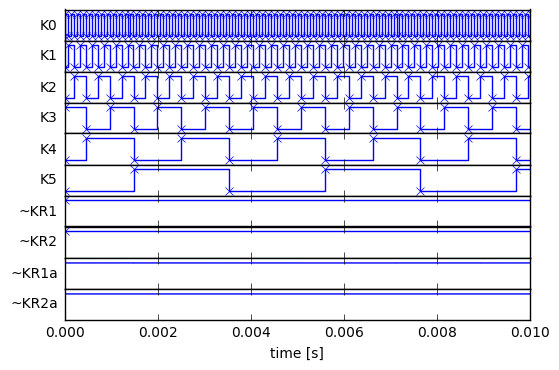

In [74]:
%matplotlib inline
from matplotlib import pyplot as plt

def plot_time_range(tmin, tmax):
    plt.figure(dpi=100, facecolor='w')
    plt.subplot(10, 1, 1)
    plt.subplots_adjust(hspace=0)
    
    def plot_one(time, data, plot_id, analog=False):
        plt.subplot(10, 1, plot_id + 1)
        if plot_id != 9:
            plt.gca().xaxis.set_ticklabels([])
        else:
            plt.gca().ticklabel_format(useOffset=False)
            plt.xlabel("time [s]")
        
        tmin_data = time[time <= tmin].iloc[-1]
        tmax_data = time[time >= tmax].iloc[0]
        msk = (time >= tmin_data) & (time <= tmax_data)

        if analog:
            plt.plot(time[msk], data[msk])
            plt.axis(xmin=tmin, xmax=tmax, ymin=-1, ymax=6)
        else:
            plt.step(time[msk], data[msk], "x", where='post')
            plt.axis(xmin=tmin, xmax=tmax, ymin=-0.2, ymax=1.2)
        plt.yticks([])

    def ylabel(label):
        plt.ylabel(label, rotation='horizontal', horizontalalignment='right', verticalalignment='center')
    
    lut = ["K0", "K1", "K2", "K3", "K4", "K5", "~KR1", "~KR2"]
    for i in range(8):
        plot_one(traces["d%it" % i], traces["d%i" % i], i)
        ylabel(lut[i])

    plot_one(traces["at"], traces["a6"], 8, analog=True)
    ylabel("~KR1a")
    plot_one(traces["at"], traces["a7"], 9, analog=True)
    ylabel("~KR2a")

plot_time_range(0, 0.01)

Here, we clearly see the 6-bit counter behavior, where K0 is the lowest, and K5 is the highest bit.

We can use this trace to determine the sign of each digital signal, as we do not know whether a digital 1 corresponds to +5V or to 0V, _and_ the diagrams shown above are inconsistent on whether the K3 and K4 pins are negated or not.

Luckily, in this diagram we notice that when K5 changes, all other lines drop to zero; when K4 changes, K0..K3 drop to zero, and so on. So we know that the Kx signals are all not negated (i.e., they are K0...K5 and not !K0..!K5).

The KR1 and KR2 signals, however, are in fact negated, as they are 1 (approx +5V in the analog signal), and jump to 0 when a keypress is detected.

To determine what happens when a key _is_ pressed, let's look at a trace around a keypress:

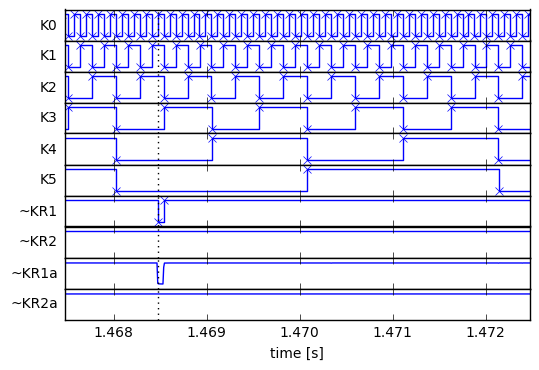

In [96]:
t_keypress = traces["d6t"][traces["d6"] == 0].iloc[0]

plot_time_range(t_keypress - 0.001, t_keypress + 0.004)

for subplot in range(10):
    plt.subplot(10, 1, subplot + 1)
    plt.axvline(t_keypress, color="k", linestyle=":")


The full detection cycle starts at t=1.468s, and runs until just after 1.472s. (The clock runs at 15.7KHz, and this is divided by 64 through the 6-bit counter, giving a cycle time of around 4 ms). At t=1.4685s, !KR1 drops, indicating a keypress. One clock tick later, !KR1 comes back up again. The value of K5..K0 between these times determines the key pressed.

We can then determine _which_ key by reading the counter value by hand from K5..K0: 0b000111 = 7.

Which key does this correspond to? It's a little bit complicated: there are a few references around:

1. [AtariAge forums](https://atariage.com/forums/topic/188172-pokey-keyboard-codes/),
2. [AtariAge forums](https://atariage.com/forums/topic/257520-1200xl-keyboard-question/) has a [diagram attached for the 1200XL](https://atariage.com/forums/uploads/monthly_08_2013/post-26063-0-81002200-1377636509.gif) which can be used for a manual lookup,
3. [XEKeyboard](https://github.com/znac049/XEKeyboard/blob/master/XEKeyboard/XEKeyboard.ino) has the same listas (1), but with all values NOTed,
4. [The Hatari source](https://github.com/libretro/hatari/blob/master/src/keymap.c) has a mapping that is entirely different (with values that go above 64, so likely not the right mapping).
5. [PixelPracht](http://blog.pixelpracht.net/?p=710) has a nice mapping from scanline to key for the 1200XL, but does not document how this maps to the connections on the 4051,

By trying the various options, we notice that (3) gives us `FLAG` as first keypresses, which seems like a good way to go (especially when compared to `*AL;` from (1)). Let's load (3) into a dictionary:

In [100]:
scancodes = {
  0: 'A',    1: 'S',     2: 'G',  3: 'CAPS', 
  5: 'D',    6: 'H',     7: 'F',  8: '>',   9: '<',
 10: '8',   11: 'DEL',  12: '7', 13: '0',
 15: '9',   16: 'Q',    17: 'W', 18: 'T',   19: 'TAB',
 20: 'Y',   21: 'E',             23: 'R',   24: 'INV',
 25: '/',   26: 'M',             28: 'N',   29: 'FSTOP',
 30: ' ',   31: ',',    32: '1', 33: '2',   34: '5',
 35: 'ESC', 36: '6',    37: '3',            39: '4',
 40: 'Z',   41: 'X',    42: 'B',    
 45: 'C',   46: 'HELP', 47: 'V', 48: '=',   49: '-',
 50: 'I',   51: 'RET',  52: 'U', 53: 'P',
 55: 'O',   56: '*',    57: '+', 58: 'K',
 61: ';',               62: 'J', 63: 'L'
}

We can now walk through each scan cycle, and print out a key if a key is detected. First, we determine each cycle transition from when K5 goes down, and use this to plot 3 cycles where the 'F' is pressed:

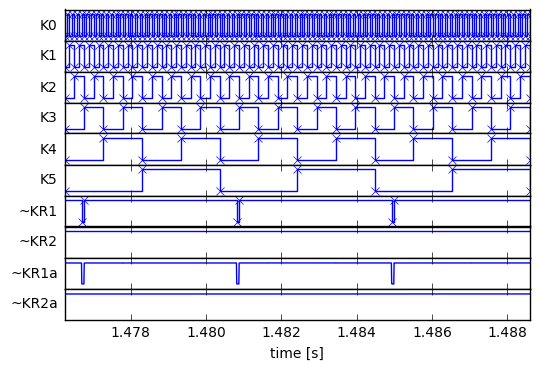

In [118]:
cycle_starts = traces["d5t"][traces["d5"] == 0].as_matrix()

plot_time_range(cycle_starts[359], cycle_starts[362])

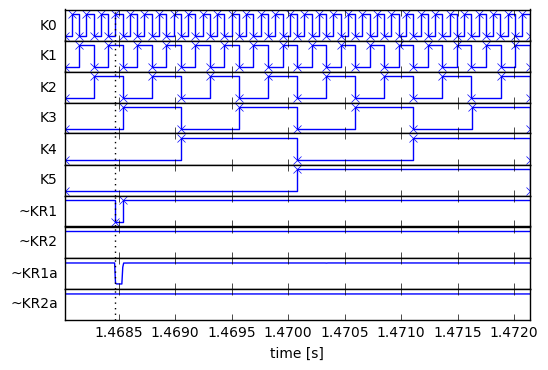

In [135]:
# loop over each combination of start and end times given an array of start time. We combine the list of start times
# with itself, but one index shifted: e.g. [0, 1, 2, 3] then becomes [(0, 1), (1, 2), (2, 3)]. We skip the first scan
# due to the initialization of the d6 signal in the logic analyzer.
for i, (t0, t1) in enumerate(zip(cycle_starts[1:-1], cycle_starts[2:])):
    
    # try to find if there is a keypress in this cycle
    KR1_transition_idx = np.where((traces["d6t"] >= t0) & (traces["d6t"] <= t1))[0]
    
    if len(KR1_transition_idx) == 0:
        continue
        
    if len(KR1_transition_idx) > 2:
        # one keypress results in two transitions: 1 -> 0 and 0 -> 1.
        raise Exception("More than one keypress?")
    
    plot_time_range(t0, t1)
    
    t_keypress = traces["d6t"][KR1_transition_idx[0]]

    for subplot in range(10):
        plt.subplot(10, 1, subplot + 1)
        plt.axvline(t_keypress, color="k", linestyle=":")
        
    break

Here, we have again found the first keypress, so the detection mechanism seems to work!
Now let's determine the keycode automatically from the K0..K5 signals. This is not entirely trivial,
as we only know the transitions. So instead of directly looking up their value, we determine their 
last known transition, and get their current value from that. We add a small time delta of 1/4 clock cycle to the lookup
for K0, as the timing of the !KR1 signal might be slightly different from that of the K0 signal.

In [132]:
delta_t = (1/15700) * 0.25
k0 = traces["d0"][traces["d0t"] <= t_keypress + delta_t].iloc[-1]
k1 = traces["d1"][traces["d1t"] <= t_keypress].iloc[-1]
k2 = traces["d2"][traces["d2t"] <= t_keypress].iloc[-1]
k3 = traces["d3"][traces["d3t"] <= t_keypress].iloc[-1]
k4 = traces["d4"][traces["d4t"] <= t_keypress].iloc[-1]
k5 = traces["d5"][traces["d5t"] <= t_keypress].iloc[-1]

scancode = k0 + 2*k1 + 4*k2 + 8*k3 + 16*k4 + 32*k5

key = scancodes.get(scancode, "???")

print("t=%.03fs 0b%i%i%i%i%i%i %i %s" % (t_keypress, k5, k4, k3, k2, k1, k0, scancode, key))

t=1.468s 0b000111 7 F


Combining:

In [137]:
# loop over each combination of start and end times given an array of start time. We combine the list of start times
# with itself, but one index shifted: e.g. [0, 1, 2, 3] then becomes [(0, 1), (1, 2), (2, 3)]. We skip the first scan
# due to the initialization of the d6 signal in the logic analyzer.
for i, (t0, t1) in enumerate(zip(cycle_starts[1:-1], cycle_starts[2:])):
    
    # try to find if there is a keypress in this cycle
    KR1_transition_idx = np.where((traces["d6t"] >= t0) & (traces["d6t"] <= t1))[0]
    
    if len(KR1_transition_idx) == 0:
        continue
        
    if len(KR1_transition_idx) > 2:
        # one keypress results in two transitions: 1 -> 0 and 0 -> 1.
        raise Exception("More than one keypress?")
    
    t_keypress = traces["d6t"][KR1_transition_idx[0]]

    delta_t = (1/15700) * 0.25
    k0 = traces["d0"][traces["d0t"] <= t_keypress + delta_t].iloc[-1]
    k1 = traces["d1"][traces["d1t"] <= t_keypress].iloc[-1]
    k2 = traces["d2"][traces["d2t"] <= t_keypress].iloc[-1]
    k3 = traces["d3"][traces["d3t"] <= t_keypress].iloc[-1]
    k4 = traces["d4"][traces["d4t"] <= t_keypress].iloc[-1]
    k5 = traces["d5"][traces["d5t"] <= t_keypress].iloc[-1]

    scancode = k0 + 2*k1 + 4*k2 + 8*k3 + 16*k4 + 32*k5

    key = scancodes.get(scancode, "???")

    print("t=%.03fs 0b%i%i%i%i%i%i %i %s" % (t_keypress, k5, k4, k3, k2, k1, k0, scancode, key))

t=1.468s 0b000111 7 F
t=1.473s 0b000111 7 F
t=1.477s 0b000111 7 F
t=1.481s 0b000111 7 F
t=1.485s 0b000111 7 F
t=1.616s 0b111111 63 L
t=1.620s 0b111111 63 L
t=1.624s 0b111111 63 L
t=1.628s 0b111111 63 L
t=1.633s 0b111111 63 L


Exception: More than one keypress?

That's not good! Let's investigate this in a bit more detail:

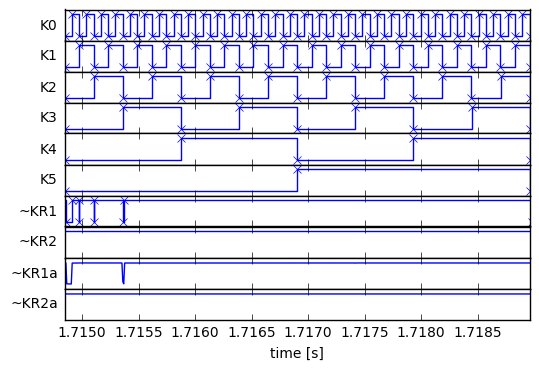

In [141]:
plot_time_range(t0, t1)

We notice there is a clock cycle length dip at the beginning of the cycle, and three smaller dips later on.
What are the widths of the various dips?

In [150]:
downs = traces["d6t"][KR1_transition_idx][::2].as_matrix()
ups = traces["d6t"][KR1_transition_idx][1::2].as_matrix()

ups-downs

array([4.9710274e-05, 1.1920929e-07, 1.1920929e-07, 1.0132790e-05],
      dtype=float32)

So let's filter out all dips that are shorter than 25µs, and continue:

In [155]:
# loop over each combination of start and end times given an array of start time. We combine the list of start times
# with itself, but one index shifted: e.g. [0, 1, 2, 3] then becomes [(0, 1), (1, 2), (2, 3)]. We skip the first scan
# due to the initialization of the d6 signal in the logic analyzer.
for i, (t0, t1) in enumerate(zip(cycle_starts[1:-1], cycle_starts[2:])):
    
    # try to find if there is a keypress in this cycle
    KR1_transition_idx = np.where((traces["d6t"] >= t0) & (traces["d6t"] <= t1))[0]
    
    downs = traces["d6t"][KR1_transition_idx][::2].as_matrix()
    ups = traces["d6t"][KR1_transition_idx][1::2].as_matrix()
    
    real_downs = downs[np.where(ups - downs > 2.5e-5)]

    if len(real_downs) == 0:
        continue
        
    if len(real_downs) > 1:
        raise Exception("More than one keypress?")
    
    t_keypress = real_downs[0]

    delta_t = (1/15700) * 0.25
    k0 = traces["d0"][traces["d0t"] <= t_keypress + delta_t].iloc[-1]
    k1 = traces["d1"][traces["d1t"] <= t_keypress].iloc[-1]
    k2 = traces["d2"][traces["d2t"] <= t_keypress].iloc[-1]
    k3 = traces["d3"][traces["d3t"] <= t_keypress].iloc[-1]
    k4 = traces["d4"][traces["d4t"] <= t_keypress].iloc[-1]
    k5 = traces["d5"][traces["d5t"] <= t_keypress].iloc[-1]

    scancode = k0 + 2*k1 + 4*k2 + 8*k3 + 16*k4 + 32*k5

    key = scancodes.get(scancode, "???")

    print("t=%.03fs 0b%i%i%i%i%i%i %i %s" % (t_keypress, k5, k4, k3, k2, k1, k0, scancode, key))

t=1.468s 0b000111 7 F
t=1.473s 0b000111 7 F
t=1.477s 0b000111 7 F
t=1.481s 0b000111 7 F
t=1.485s 0b000111 7 F
t=1.616s 0b111111 63 L
t=1.620s 0b111111 63 L
t=1.624s 0b111111 63 L
t=1.628s 0b111111 63 L
t=1.633s 0b111111 63 L
t=1.715s 0b000000 0 A
t=1.719s 0b000000 0 A
t=1.723s 0b000000 0 A
t=1.727s 0b000000 0 A
t=1.731s 0b000000 0 A
t=1.859s 0b000010 2 G
t=1.863s 0b000010 2 G
t=1.867s 0b000010 2 G
t=1.871s 0b000010 2 G
t=1.875s 0b000010 2 G
t=2.504s 0b111101 61 ;
t=2.509s 0b111101 61 ;
t=2.513s 0b111101 61 ;
t=2.517s 0b111101 61 ;
t=2.521s 0b111101 61 ;
t=3.058s 0b011110 30  
t=3.062s 0b011110 30  
t=3.066s 0b011110 30  
t=3.070s 0b011110 30  
t=3.074s 0b011110 30  
t=4.764s 0b001010 10 8
t=4.768s 0b001010 10 8
t=4.772s 0b001010 10 8
t=4.776s 0b001010 10 8
t=4.780s 0b001010 10 8
t=5.264s 0b110001 49 -
t=5.268s 0b110001 49 -
t=5.272s 0b110001 49 -
t=5.276s 0b110001 49 -
t=5.280s 0b110001 49 -
t=5.716s 0b101010 42 B
t=5.720s 0b101010 42 B
t=5.724s 0b101010 42 B
t=5.728s 0b101010 42 B
t=5

With some manual parsing, we get
```
flag; 8-bit-hardware-keylogger
```
which __almost__ is the flag: we did not parse the KR2 data line yet. Almost nothing happens there:

In [159]:
traces["d7t"][~np.isnan(traces["d7t"])]

0     0.000000
1     2.503183
2     2.503690
3     2.507289
4     2.507799
5     2.511396
6     2.511904
7     2.515508
8     2.516016
9     2.519610
10    2.520159
Name: d7t, dtype: float32

The timestamps correspond to the semicolon. Let's plot the data in the first cycle where !KR2 changes:

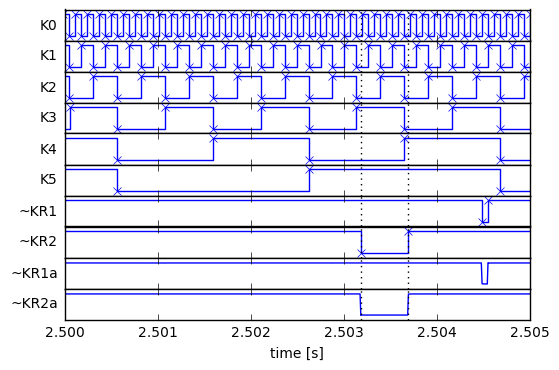

In [167]:
plot_time_range(2.500, 2.505)

for subplot in range(10):
    plt.subplot(10, 1, subplot + 1)
    plt.axvline(2.503183, color="k", linestyle=":")
    plt.axvline(2.503690, color="k", linestyle=":")


Here, we see !KR2 drops for a significant period of time, from 0b10100 to 0b11000 (although the timestamps seem a bit shifted). According to the various diagrams, this corresponds to shift (which is bound to pin '5' of the high-bit 4051). As on modern keyboards, shift-; is :, and this gives use the correct flag:

```
flag: 8-bit-hardware-keylogger
```